# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [328]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, date_format, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [ ]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()
data.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

### Dataset size, schema & column description

In [5]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 18


In [6]:
# Schema
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



<p style="color:red">TODO: column description</p>

### Duplicate rows

In [7]:
# Any duplicate rows? - No
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


### Missing values

In [8]:
# Filter by missing value (either null of empty - if string)
def filter_missing(data, name):
    return data.where((col(name).isNull()) | (col(name) == ''))

# Show count of missing values for all columns in the dataset
def show_missing(data):
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')
        
show_missing(data)

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


In [9]:
# Are 8346 missing values in user's column firstName, gender, lastName, location, registration, userAgent, userId correlated 
# occurring in the same rows? - Yes

class Missing:
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        self.missing_data = filter_missing(data, name) 
        return self  
    
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


**What kind of user has a missing userId?**

In [10]:
filter_missing(data, 'userId').select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [11]:
filter_missing(data, 'userId').select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



As we can see, the missing user is an **unregistered** user. 

**Can we safely remove the rows with missing users?**

Yes, since our target, the *churned user*, is a **registered** user.

In [9]:
# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(data) 

artist: 50046
auth: 0
firstName: 0
gender: 0
itemInSession: 0
lastName: 0
length: 50046
level: 0
location: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 50046
status: 0
ts: 0
userAgent: 0
userId: 0


In [10]:
# Check count of deleted rows
original_count - data.count()

8346

### Remove unrelevant columns

We identify 2 columns that are not relevant for our analysis:

- *firstName* and *lastName* which depend on *userId* and do not provide any additional information relevant for the analysis that has not been already included in *userId*.

In [11]:
# How many different keys (firstName, lastName) exist in our dataset?
data.select('firstName', 'lastName').dropDuplicates().count()

# 225 - The same as userIds

225

In [107]:
# Check if every firstName-lastName is associated to exactly one userId
data.select('firstName', 'lastName', 'userid') \
    .dropDuplicates() \
    .groupby('firstName', 'lastName') \
    .count() \
    .where(col('count') > 1) \
    .count()

AnalysisException: cannot resolve '`firstName`' given input columns: [artist, auth, churn, city, gender, itemInSession, lastLevel, length, level, method, page, regDate, registration, sessionId, song, state, status, ts, tsDate, userAgent, userId, userRowDescId, userRowId];;
'Project ['firstName, 'lastName, userid#24]
+- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24, churn#4593) AS churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740]
   +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664, <lambda>(userId#24) AS lastLevel#4740]
      +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664]
         +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664, userRowDescId#4664]
            +- Window [row_number() windowspecdefinition(userId#24, ts#22L DESC NULLS LAST, itemInSession#11L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowDescId#4664], [userId#24], [ts#22L DESC NULLS LAST, itemInSession#11L DESC NULLS LAST]
               +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641]
                  +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641]
                     +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowId#4641]
                        +- Window [row_number() windowspecdefinition(userId#24, ts#22L ASC NULLS FIRST, itemInSession#11L ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowId#4641], [userId#24], [ts#22L ASC NULLS FIRST, itemInSession#11L ASC NULLS FIRST]
                           +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593]
                              +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24) AS churn#4593]
                                 +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24) AS churn#4478]
                                    +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220]
                                       +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, split(location#15, ,, -1)[1] AS state#1220]
                                          +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, split(location#15, ,, -1)[0] AS city#1200]
                                             +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, cast((cast(ts#22L as double) / cast(1000.0 as double)) as timestamp) AS tsDate#1165]
                                                +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, cast((cast(registration#18L as double) / cast(1000.0 as double)) as timestamp) AS regDate#1147]
                                                   +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24]
                                                      +- Project [artist#7, auth#8, gender#10, itemInSession#11L, lastName#12, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24]
                                                         +- Filter NOT (isnull(userId#24) OR (userId#24 = ))
                                                            +- Relation[artist#7,auth#8,firstName#9,gender#10,itemInSession#11L,lastName#12,length#13,level#14,location#15,method#16,page#17,registration#18L,sessionId#19L,song#20,status#21L,ts#22L,userAgent#23,userId#24] json


In [13]:
# Exclude userId-dependent columns
data = data.drop('firstName')
data = data.drop('lastName')

### Convert unix timestamp into TimestampType  (*ts*, *registration*)

In [16]:
data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57))]

### Split location into *Place* and *State*

The location column contains *place* and *state*. Let's split the composed information into 2 features.

In [ ]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [21]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Common Functions

In [110]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

# Fetch values (categories) of a given feature
def get_categories(feature):
    return data.select(feature).dropDuplicates().sort(feature)

# Get list of categories of a given feature
def get_categories_list(feature):
    return [str(row[feature]) for row in get_categories(feature).collect()]

### Preliminary Analysis

In [154]:
# Count of unique users
data.select("userId").dropDuplicates().count()

225

In [47]:
# Count of unique sessions
data.select("sessionId").dropDuplicates().count()

2312

#### Log level: *Level*, *Status*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


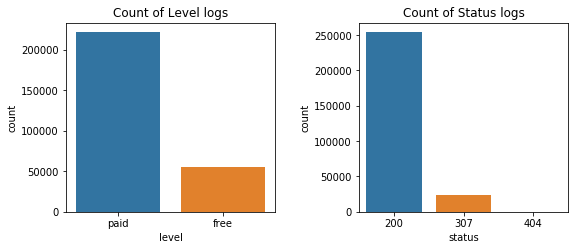

In [60]:
set_plot_size(9, 3);
plt.subplots_adjust(top=1.0, wspace=0.4)

# 1. Count log events by level categories (paid, free) 
df = data.select('level').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df, x = 'level');
ax = plt.gca()
ax.set_title('Count of Level logs');

# 2. Count log events by status categories
df = data.select('status').toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'status');
ax = plt.gca()
ax.set_title('Count of Status logs');

fig.tight_layout();

#### Log level: *page*

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


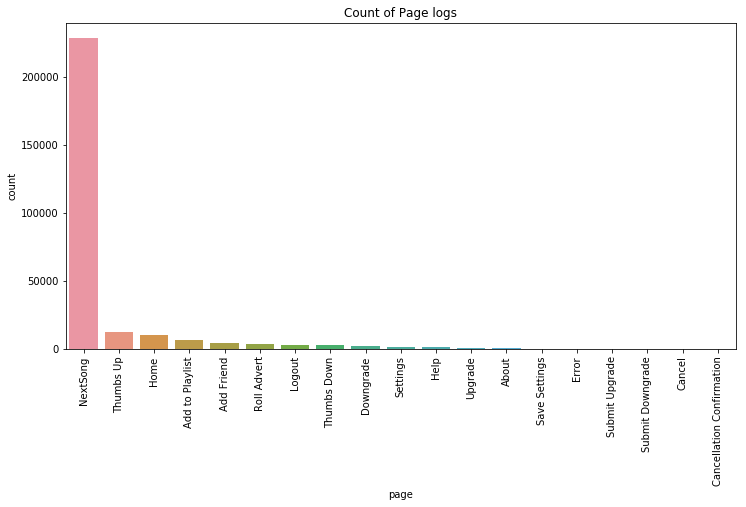

In [32]:
# Count log events by page categories
data.select('page').dropDuplicates().sort('page').show(truncate=False)

set_plot_size(12, 6)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Count of Page logs');

#### User/Session level: *logs per user*, *sessions per user*, *duration per session*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


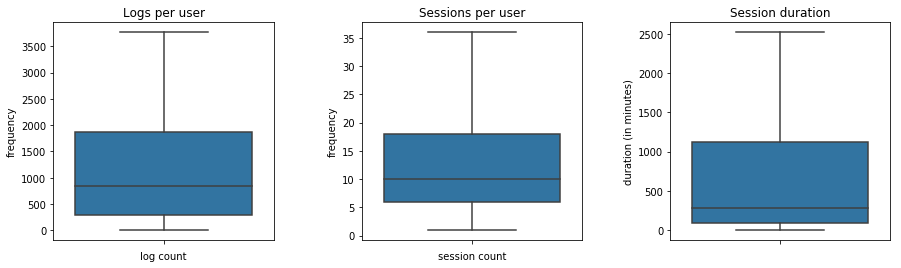

In [74]:
set_plot_size(15, 4);
plt.subplots_adjust(wspace=0.4)

# 1. Logs per user
#data.groupby('userId').count().describe('count').show()
plt.subplot(1, 3, 1)
df_user_logs = data.groupby('userId').count().toPandas()
sb.boxplot(data = df_user_logs, y = 'count', showfliers=False);
plt.xlabel('log count')
plt.ylabel('frequency')
ax = plt.gca()
ax.set_title('Logs per user');

# 2. Sessions per user
gdata = data.groupby('userId', 'sessionId').count() \
    .groupby('userId').count()
#gdata.describe('count').show()
plt.subplot(1, 3, 2)
df_user_sessions = gdata.toPandas()
sb.boxplot(data = df_user_sessions, y = 'count', showfliers=False);
plt.xlabel('session count')
plt.ylabel('frequency')
ax = plt.gca()
ax.set_title('Sessions per user');

# 3. Session duration
df_session_duration = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()
#print(df.duration.describe())
plt.subplot(1, 3, 3)
sb.boxplot(data = df_session_duration, y = 'duration', showfliers=False);
plt.ylabel('duration (in minutes)')
ax = plt.gca()
ax.set_title('Session duration');

#### User level: *Gender*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


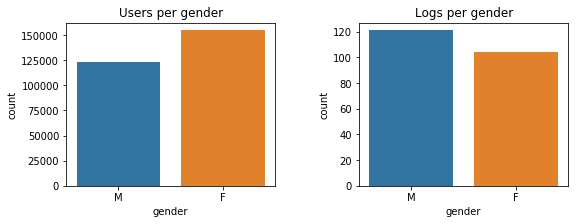

In [73]:
set_plot_size(9, 3);
plt.subplots_adjust(wspace=0.4)

# 1. Count users per gender
df_gender_logs = data.select('gender').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df_gender_logs, x = 'gender', order = ['M','F']).set_title('Users per gender')

# 2. Count logs per gender
df_gender_users = data.groupby('userId', 'gender').count().toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df_gender_users, x = 'gender', order = ['M','F']).set_title('Logs per gender');

fig.tight_layout();

#### User level: *State*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


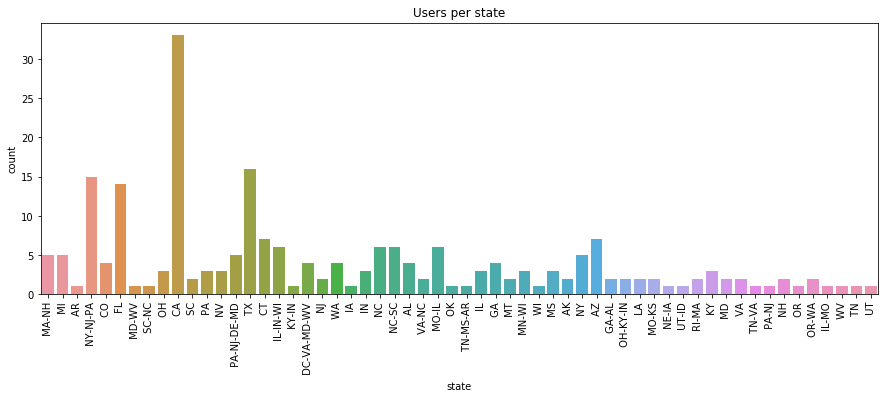

In [184]:
# Count users per state
df_user_state = data.select('userId', 'state').dropDuplicates().toPandas()

set_plot_size(15, 5);
sb.countplot(data = df_user_state, x = 'state').set_title('Users per state')
plt.xticks(rotation = 90);
plt.show()

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Common Variables and Functions

In [112]:
label_names = ['non-churned', 'churned']

def get_churned_logs():
    return data.where(data.churn == 1)

def get_nonchurned_logs():
    return data.where(data.churn == 0)

#### Churn by *Cancellation Confirmation* event

In [84]:
# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))
data.take(3)

# Check
print(f"Check churned users: {get_churned_logs().select('userId').dropDuplicates().count()}")

Churned users that cancelled subscription: 52
Check churned users: 52


#### Churn by *Downgrade Submit* event

In [87]:
# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1)]

In [88]:
# Count donwgrade log events
data.where(data.page == 'Submit Downgrade').count()

63

When a user downgrade the **level** feature changes from *paid* to *free*. In contrast to the cancelation event which can happen only once per observation periods, a user can downgrade more than once if he or she upgrades after downgrading. Nevertheless, no matter how many times the user repeats the downgrade-upgrade cycle (*D/U event*), if the **level** is set to *free* at the end of the observation period, then we can conclude beyond any doubt that the user has changed the suscription level from *free* to *paid* due to the downgrading.

It's not important how many times the D/U occured if the *last level* is *free*, but, yes, it is important if the **last level** is *paid* since this would mean that through the D/U cycles the user has reestablished the suscription level which he or she had before D/U - **as if D/U had never happened**.

In [89]:
# Add lastLevel column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free')]

In [90]:
# Query churned users by downgrade event
downgraded = data.where((data.churn == 0) \
           & (data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free')) \
    .select('userId') \
    .dropDuplicates()

# Label downgraded users (churn=1)
uids = [row.userId for row in downgraded.collect()]
set_churn = udf(lambda userId, churn: 1 if userId in uids else churn, IntegerType())
data = data.withColumn('churn', set_churn('userId', 'churn'))
data.take(1)

# Check
print(f"Check churned users: {get_churned_logs().select('userId').dropDuplicates().count()}")

Check churned users: 67


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Log level
We calculate a share of logs with a selected feature for each target group (*churned*, *non-churned*).

#### Common variables and functions

In [ ]:
# Count of churned/non-churned logs
count0 = data.where(data.churn == 0).count()
count1 = data.where(data.churn == 1).count()

In [190]:
# Return total count of logs depending on churn
get_log_total = udf(lambda x: count0 if x == 0 else count1)

# Calculate share of each category relating to its churn group
def calc_log_share(feature):
    # calculate count of each category, per churn group
    df = data \
        .groupby('churn', feature) \
        .count() \
        .toPandas()
       
    totals = df.groupby('churn').sum()
    df = df.set_index('churn').join(totals, rsuffix='_total')
    df['share'] = df['count']/df['count_total']
    df = df.drop('count_total', axis=1)
    return df.reset_index()

# Plot the category share, for both churn group
def plot_share(df, feature, title, loc=1):
    # split dataset into 2 churn subsets
    df0 = df[df.churn == 0].sort_values(by=feature)
    df1 = df[df.churn == 1].sort_values(by=feature)
    
    # plot
    width = 0.35
    labels = get_categories_list(feature)
    plt.xticks(range(len(labels)), df0[feature])
    plt.xlabel(feature)
    plt.ylabel('share')
    plt.bar(np.arange(len(df0)), df0['share'], width=width)
    plt.bar(np.arange(len(df1))+ width, df1['share'], width=width)
    ax = plt.gca()
    ax.set_title(title);
    plt.legend(label_names, loc=loc)    

#### Method, Status

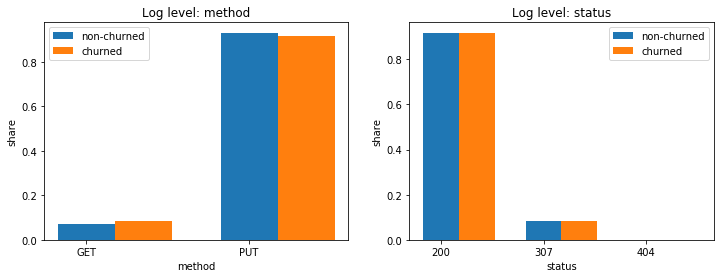

In [192]:
# Prepare data
df_log_method = calc_log_share('method')
df_log_status = calc_log_share('status')

set_plot_size(12, 4);

# 1. Method
plt.subplot(1, 2, 1)
plot_share(df_log_method, 'method', 'Log level: Method', 2)

# 2. Status
plt.subplot(1, 2, 2)
plot_share(df_log_status, 'status', 'Log level: Status')

plt.show()

#### Page: NextSong

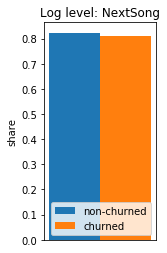

In [104]:
# Prepare data
df_log_nextSong = data.where(data.page == 'NextSong') \
    .withColumn('total', get_log_total('churn')) \
    .groupby('churn', 'total') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

# Split data by churn
df0 = df_log_nextSong[df_nextSong.churn == 0].copy()
df1 = df_log_nextSong[df_nextSong.churn == 1].copy()

# Plot
set_plot_size(2, 4);
width =0.1
plt.xticks(range(0), [])
plt.ylabel('share')
plt.bar(np.arange(1), df0['share'], width=width)
plt.bar(np.arange(1) + width, df1['share'], width=width)
ax = plt.gca()
ax.set_title('Log level: NextSong');
plt.legend(label_names, loc=4)
plt.show()

#### Page: non-NextSong (other) pages

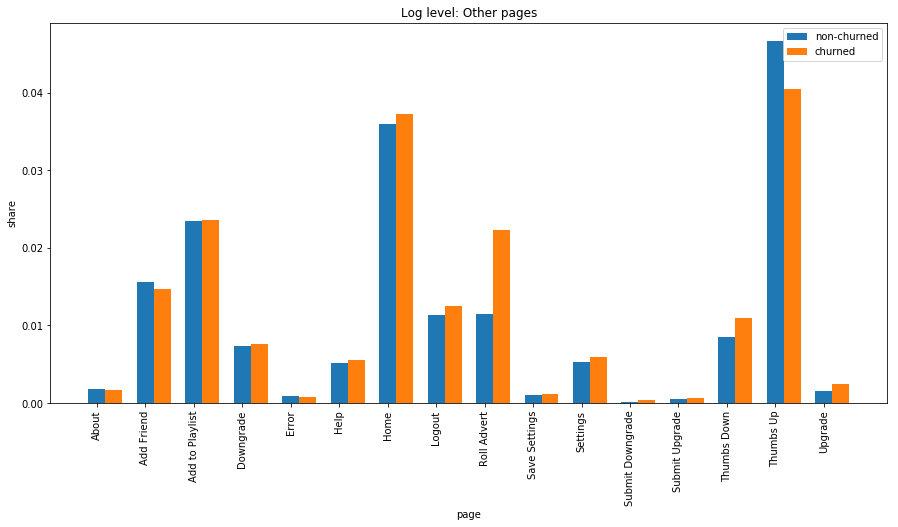

In [150]:
# Apart from NextSong event we also exclude Cancel/Cancellation Confirmation events
# that belong to the churn group only
df_log_otherPages = data.where(~data.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation'])) \
    .withColumn('total', get_log_total('churn')) \
    .groupby('churn', 'total', 'page') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

# Split data by churn
df0 = df_log_otherPages[df_log_otherPages.churn == 0].sort_values(['page', 'churn']).copy()
df1 = df_log_otherPages[df_log_otherPages.churn == 1].sort_values(['page', 'churn']).copy()

# Plot
set_plot_size(15, 7);
width = 0.35
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('share')
plt.bar(np.arange(len(df0)), df0['share'], width=width)
plt.bar(np.arange(len(df1))+width, df1['share'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Log level: Other pages');
plt.legend(label_names, loc=1)
plt.show()

### User level
We calculate a share of users with a selected feature for each target group.

#### Common variables and functions

In [95]:
# Count users for each churn group 
split = data.groupby('churn', 'userId').count()
user_count0 = split.where(split.churn == 0).count()
user_count1 = split.where(split.churn == 1).count()

In [152]:
get_user_total = udf(lambda x: user_count0 if x == 0 else user_count1)

# Calculate user share for each churn group
def calc_user_share(data, feature):
     return data \
        .withColumn('total', get_user_total('churn')) \
        .select('churn', 'total', 'userId', feature) \
        .dropDuplicates() \
        .groupby('churn', 'total', feature) \
        .count() \
        .withColumn('share', col('count')/col('total')) \
        .sort('churn', feature) \
        .toPandas()

#### User level: *Gender*

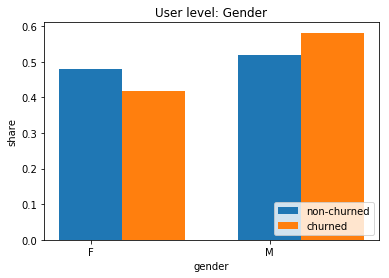

In [195]:
df_user_gender = calc_user_share(data, 'gender')
plot_share(df_user_gender, 'gender', 'User level: Gender', 4)

#### User level: *Level*
Since a *level* is a **user-time dependent feature** we will observe here the level at the beginning of the observation period (*First level*) and the level at the end of the observation period (*Last level*). (Check the next analysis for user-time presentation of *level* data.)

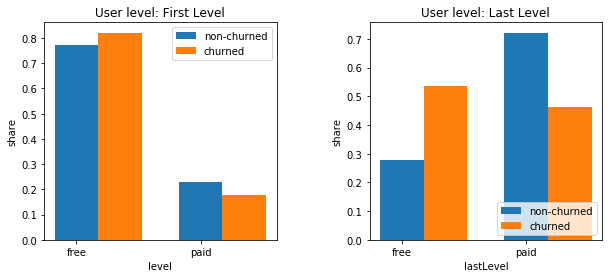

In [197]:
# Prepare data
df_user_firstLevel = calc_user_share(data.where(data.userRowId == 1).select('churn', 'userId', 'level'), 'level')
df_user_lastLevel = calc_user_share(data, 'lastLevel')

set_plot_size(10, 4);
plt.subplots_adjust(wspace=0.4)

# 1. First Level
plt.subplot(1, 2, 1)
plot_share(df_user_firstLevel, 'level', 'User level: First Level')

# 2. Last level
plt.subplot(1, 2, 2)
plot_share(df_user_lastLevel, 'lastLevel', 'User level: Last Level', 4)

#### User-Time level: *Level*
Level category statistics per day

In [299]:
# get date string
def get_date_str(month, day):
    return '2018-' + str(month).zfill(2) + '-' + str(day).zfill(2)

# get date
def get_date(month, day):
    try:
        date_str = get_date_str(month, day)
        return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        return None   

# Return true if the date string is a valid date
def validate_date(month, day):
    try:
        date_str = get_date_str(month, day)
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False   
    
# get dates generator that returns (month, day) tuple between date1 and date2 
def get_dates_gen(date1, date2):
    for m in range(date1.month, date2.month+1):
        for d in range(1, 31+1):
            date = get_date(m, d)
            if date == None or date <= date1 or date >= date2:
                continue                      
            yield date    

# get user_time matrix row
def get_ut_row(userId, date, level):
    return {
        'userId': userId,
        'date': date,
        'level': level
    }

# get default (starting) date
def get_default_date():
    return datetime.datetime.strptime('2018-09-30', '%Y-%m-%d').date()


##### Add date components

In [277]:
# Add year, month, day columns
data = data.withColumn('date', to_date('tsDate'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', date=datetime.date(2018, 11, 21))]

##### Extract unique user-time data with level information

In [282]:
# Extract user-time distinct rows with level value
extracted = data \
    .groupby('userId', 'date') \
    .agg(max('userRowId').alias('rowid')) \
    .select(col('userId').alias('uid'), 'date', 'rowid')
    
# Note: if a user has more than 1 different level per day, then we take the last level
user_time_rows = extracted \
    .join(data, (extracted.uid == data.userId) & (extracted.rowid == data.userRowId), how='inner') \
    .select(data.userId, extracted.date, data.level) \
    .sort('userId', 'date') \
    .collect()

In [289]:
user_time_rows

[Row(userId='10', date=datetime.date(2018, 10, 8), level='paid'),
 Row(userId='10', date=datetime.date(2018, 10, 18), level='paid'),
 Row(userId='10', date=datetime.date(2018, 10, 19), level='paid'),
 Row(userId='10', date=datetime.date(2018, 10, 29), level='paid'),
 Row(userId='10', date=datetime.date(2018, 10, 30), level='paid'),
 Row(userId='10', date=datetime.date(2018, 11, 3), level='paid'),
 Row(userId='10', date=datetime.date(2018, 11, 15), level='paid'),
 Row(userId='10', date=datetime.date(2018, 11, 16), level='paid'),
 Row(userId='10', date=datetime.date(2018, 11, 19), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 2), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 3), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 4), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 7), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 9), level='paid'),
 Row(userId='100', date=datetime.date(2018, 10, 10), level='paid

##### Add missing user-time rows

In [290]:
# Observation period
data.agg(min('date'), max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [300]:
# Build user-time dimension matrix for the whole observation period from Oct 1, 2018 to Dec 3, 2018.
# Important: if in time t2 user has no user_time row, then it holds:
#
#    level(user, t2) = level(user, t1)
#

# user set
users = {row.userId for row in user_time_rows}

# user-time dimension matrix
ut_matrix = []

# current user-time level - fill it with default (None) values 
current_levels = dict()
for userId in users:
    current_levels[userId] = None

# convert user_time rows into pandas dataframe (for easier filtering)
utdf = pd.DataFrame(user_time_rows)
utdf.columns = ['userId', 'date', 'level']

# current dimension variables - defaults are set on Sept 30
last_userId, last_date = '-1', get_default_date()

# loop through the user-time rows sorted by userId, month, day
for row in user_time_rows:
    
    userId = row.userId
    
    # reset last date when user changes
    if userId != last_userId:
        last_date = get_default_date()
    
    # get current user level
    last_level = current_levels[userId]
    
    # add missing dimensions (up till current row date)
    #  level := last_level
    # Note: we skip None levels that represent missing logs before the first user log.
    if last_level != None:
        for date in get_dates_gen(last_date, row.date):
            ut_matrix.append(get_ut_row(userId, date, last_level))
        
    # add level for current row date
    ut_matrix.append(get_ut_row(userId, row.date, row.level))
       
    # handle history variables
    last_date = row.date       
    last_userId = userId
    current_levels[userId] = row.level
               

In [302]:
ut_matrix[0]

{'date': datetime.date(2018, 10, 8), 'level': 'paid', 'userId': '10'}

##### Calculate share of level per churn group, for each day in the observation period 

In [304]:
# Prepare churn data
churn_df = data.select('userId', 'churn').dropDuplicates().toPandas()

# Convert user_time matrix to pandas framework
ut_df = pd.DataFrame(ut_matrix)
ut_df = ut_df[['userId', 'date', 'level']]

# Add churn indicator
ut_df = ut_df.merge(churn_df, on='userId')

In [307]:
# Prepare agg totals per day and churn group
level_totals_df = ut_df \
    .groupby(['churn', 'date']) \
    .size() \
    .reset_index(name='count') \
    .rename(columns={'count': 'total'})

# create level share dataframe
level_share_df = ut_df \
    .groupby(['churn', 'date', 'level']) \
    .size() \
    .reset_index(name='count') \
    .merge(level_totals_df, on=['churn', 'date'])
    
# calc share
level_share_df['share'] = level_share_df['count']/level_share_df['total']

##### Plot total count of level category per day

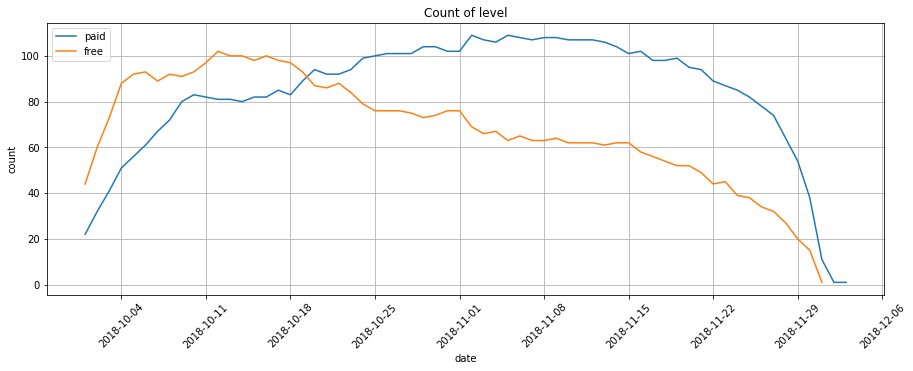

In [312]:
# Prepare agg totals per day and churn group
level_count_df = ut_df \
    .groupby(['level', 'date']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['date'])

# Plot
paid = level_count_df[level_count_df.level == 'paid']['count']
free = level_count_df[level_count_df.level == 'free']['count']
dates_paid = level_count_df[level_count_df.level == 'paid']['date']
dates_free = level_count_df[level_count_df.level == 'free']['date']

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

ax.plot(dates_paid, paid)
ax.plot(dates_free, free)

ax.set(xlabel='date', ylabel='count', title='Count of level')
ax.grid()
plt.legend(['paid', 'free'], loc=2)
plt.xticks(rotation = 45);
plt.show()

##### Plot share of a level category by churn group per day

In [309]:
# Share of a given level, per churn group
def plot_level_share(df, level):
    df_share = df[(df.level == level)]

    shares0 = df_share[df_share.churn == 0]['share']
    shares1 = df_share[df_share.churn == 1]['share']
    dates0 = df_share[df_share.churn == 0]['date']
    dates1 = df_share[df_share.churn == 1]['date']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    # plot both lines
    ax.plot(dates0, shares0)
    ax.plot(dates1, shares1)

    ax.set(xlabel='date', ylabel='share', title="Share of level='" + level + "'")
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = 45);
    plt.show()

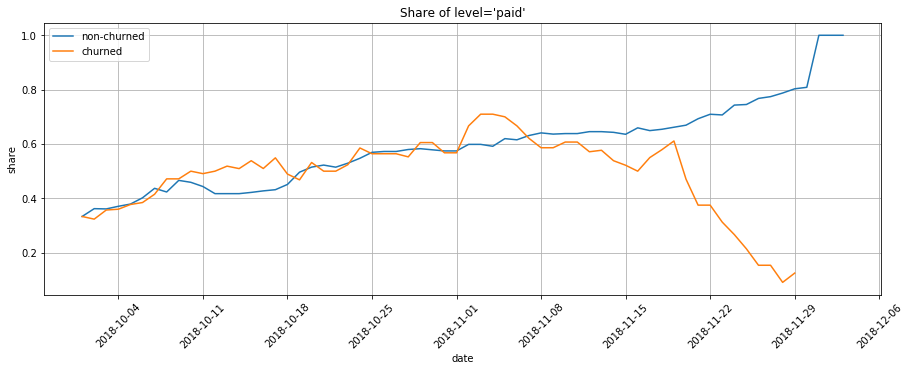

In [310]:
plot_level_share(level_share_df, 'paid')

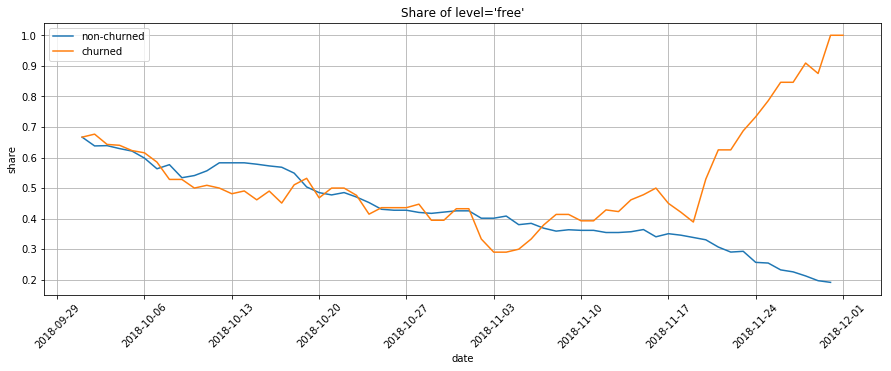

In [311]:
plot_level_share(level_share_df, 'free')

#### Song-Time level
Song statistics per day

In [223]:
datetime.datetime.now().date()

datetime.date(2020, 8, 2)

In [313]:
song_count_df = data \
    .where(data.page == 'NextSong') \
    .groupby('date') \
    .count() \
    .sort('date') \
    .toPandas()

In [336]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [337]:
data \
    .where(data.userId == '10') \
    .withColumn('week', date_format('date', 'w')) \
    .show()

+--------------------+---------+------+-------------+---------+-----+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+------+-----+-----+---------+-------------+---------+----------+----+
|              artist|     auth|gender|itemInSession|   length|level|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|            regDate|             tsDate|  city|state|churn|userRowId|userRowDescId|lastLevel|      date|week|
+--------------------+---------+------+-------------+---------+-----+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+------+-----+-----+---------+-------------+---------+----------+----+
|                null|Logged In|     M|           98|     null| paid|   GET|      Downgrade|1538159495000|     1

In [ ]:
data \
    .where(data.page == 'NextSong') \
    .groupby('date') \
    .count() \
    .withColumn('week', date_format('date', 'w')) \
    .groupby('week') \
    .count() \
    .sort('week') \
    .show()

In [322]:
song_weekcount_df = song_count_df \
    .groupby(song_count_df.date) \
    .size()

AttributeError: 'Series' object has no attribute 'isocalendar'

In [317]:
song_count_df

,date,count
0,2018-10-01,3075
1,2018-10-02,3322
2,2018-10-03,3454
3,2018-10-04,3625
4,2018-10-05,3503
5,2018-10-06,3145
6,2018-10-07,2328
7,2018-10-08,3941
8,2018-10-09,4434
9,2018-10-10,5121


In [320]:
get_default_date().isocalendar()[1]

39

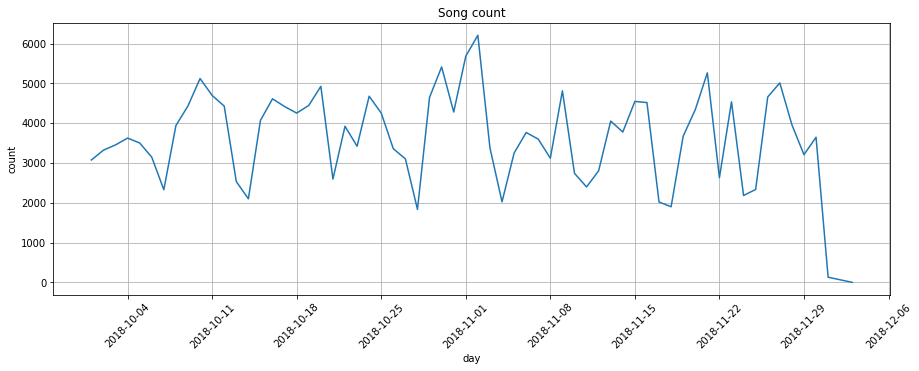

In [318]:
# Prepare agg totals per day and churn group

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

ax.plot(song_count_df['date'], song_count_df['count'])

ax.set(xlabel='day', ylabel='count', title='Song count')
ax.grid()
plt.xticks(rotation = 45);
plt.show()

#### Session

In [137]:
# Prepare dataset
df = data.groupby('userId', 'churn', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000.0).alias('duration')) \
    .groupby('userId', 'churn') \
    .agg(avg('logCount').alias('avgLogsPerSession'), \
         avg('duration').alias('avgDurationPerSession')) \
    .toPandas()

#### Session: Average logs per user session

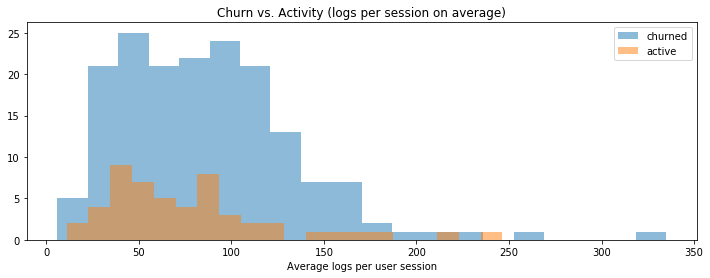

In [139]:
# plot
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgLogsPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgLogsPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average logs per user session')
ax = plt.gca()
ax.set_title('Churn vs. Activity (logs per session on average)');
plt.legend(loc='upper right')
plt.show()

#### Session: Average duration logs per user session

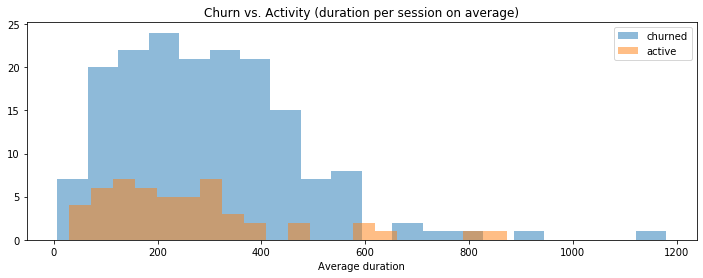

In [140]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgDurationPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgDurationPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average duration')
ax = plt.gca()
ax.set_title('Churn vs. Activity (duration per session on average)');
plt.legend(loc='upper right')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.